Potato leaf disease  model trained and got 89% accuracy

I classify potatoes into 3 types
1) Potato healthy
2) Potato early blight
3) Potato late blight

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato_diseases_images/images/potato",
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

#train, test, validation

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_ds), len(val_ds), len(test_ds)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import keras

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
54/54 [==============================] - 392s 4s/step - loss: 0.9271 - accuracy: 0.4716 - val_loss: 0.8697 - val_accuracy: 0.4688
Epoch 2/20
54/54 [==============================] - 215s 4s/step - loss: 0.7424 - accuracy: 0.6539 - val_loss: 0.5271 - val_accuracy: 0.7917
Epoch 3/20
54/54 [==============================] - 218s 4s/step - loss: 0.5278 - accuracy: 0.7703 - val_loss: 0.4613 - val_accuracy: 0.7969
Epoch 4/20
54/54 [==============================] - 211s 4s/step - loss: 0.3883 - accuracy: 0.8339 - val_loss: 0.3688 - val_accuracy: 0.8490
Epoch 5/20
54/54 [==============================] - 214s 4s/step - loss: 0.3100 - accuracy: 0.8721 - val_loss: 0.2324 - val_accuracy: 0.8958
Epoch 6/20
54/54 [==============================] - 214s 4s/step - loss: 0.2439 - accuracy: 0.9028 - val_loss: 0.2172 - val_accuracy: 0.9010
Epoch 7/20
54/54 [==============================] - 213s 4s/step - loss: 0.2264 - accuracy: 0.9091 - val_loss: 0.2150 - val_accuracy: 0.9167
Epoch 8/20
54

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 20s 2s/step - loss: 0.0970 - accuracy: 0.9648


In [19]:
model.save('P_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
model.save(history.h5)

AttributeError: ignored

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

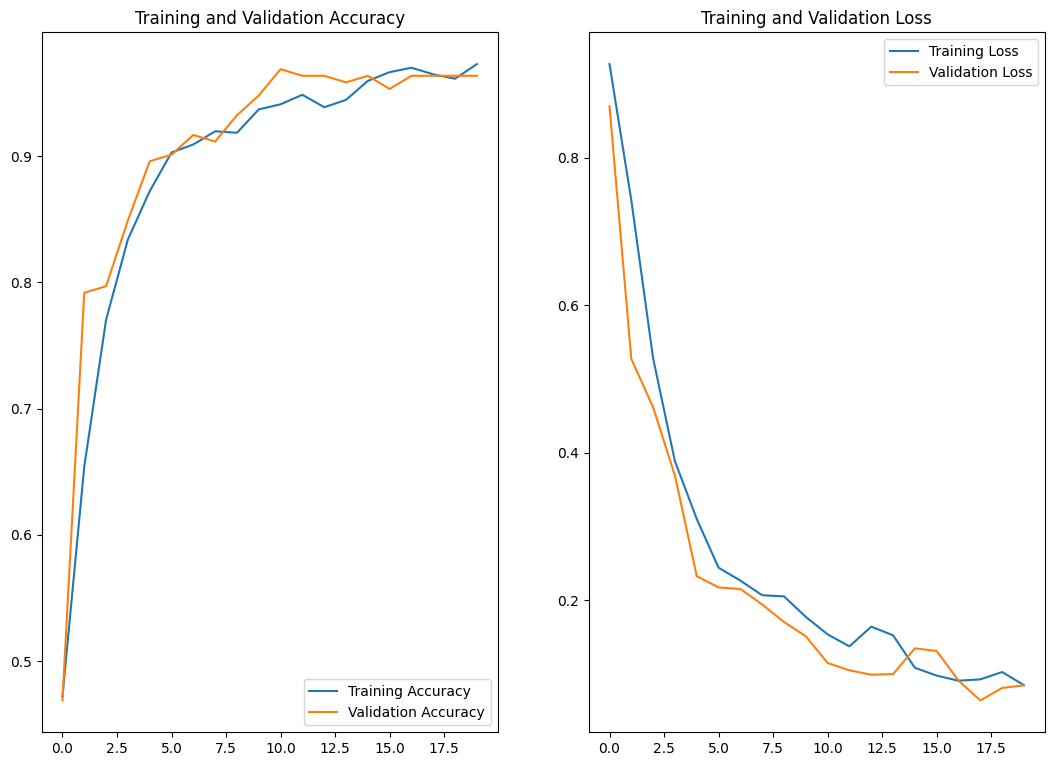

In [21]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (20,20))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


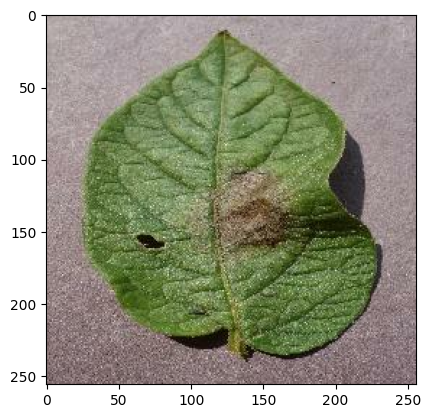

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[3].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 355ms/step
predicted label: Potato___Early_blight


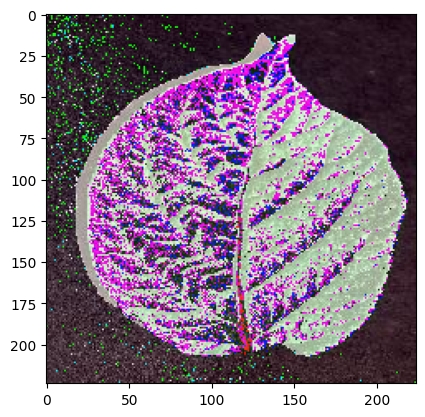

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load your external image
external_image_path = '/content/drive/MyDrive/Potato_diseases_images/images/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'
external_image = image.load_img(external_image_path, target_size=(224, 224))  # VGG16 input size is typically 224x224
external_image = image.img_to_array(external_image)
external_image = np.expand_dims(external_image, axis=0)  # Add a batch dimension

# Preprocess the external image using VGG16 preprocess_input
external_image = preprocess_input(external_image)

# Make predictions on the external image
external_image_prediction = model.predict(external_image)
predicted_label = class_names[np.argmax(external_image_prediction)]

# Display the external image and predicted label
plt.imshow(external_image[0].astype('uint8'))
print("predicted label:", predicted_label)


In [ ]:
import pickle

# Save the model using pickle
model_path = "potato_disease_model.h5"
with open(model_path, "wb") as model_file:
    pickle.dump(model, model_file)

# Print the saved model's path
print("Saved model:", model_path)


Saved model: potato_disease_model.h5


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 223ms/step
Type Of Planet ==>  Potato___Early_blight
Type Disease Of Planet ==>  Early_blight


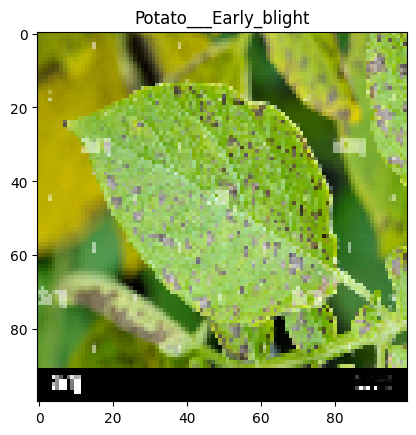

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout

import pickle

model_path = "/content/P_model.h5"
model = keras.models.load_model(model_path)


class_names = ['Potato___Early_blight',
                   'Potato___Late_blight',
                   'Potato___healthy']

path_img1 = "/content/poteto_blight.jpg"
image = cv2.imread(path_img1)
image = cv2.resize(image, (100, 100))
# new_image = np.reshape(image, [1, 100, 100, 3])
new_image = cv2.resize(image, (256, 256))
new_image = np.reshape(new_image, [1, 256, 256, 3])

prediction = model.predict(new_image)[0]
new_prediction = class_names[np.argmax(prediction)]

print("Type Of Planet ==> ", new_prediction)
print("Type Disease Of Planet ==> ", new_prediction[new_prediction.index("__") + 3:])

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(new_prediction)
plt.show()


In [ ]:
# Load the pre-trained model
model = keras.models.load_model('/content/20230122_092444.h5')

# Prepare your dataset for evaluation (replace this with your data loading code)
test_data, test_labels = load_and_preprocess_test_data()

# Evaluate the model and retrieve the accuracy
accuracy = model.evaluate(test_data, test_labels, verbose=0)[1]

print(f'Accuracy: {accuracy}')



NameError: ignored

In [ ]:
model = keras.models.load_model('/content/20230122_092444.h5')
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 644ms/step - loss: 4.9045e-04 - accuracy: 1.0000


In [ ]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('/content/20230122_092444.h5')  # Replace with the path to your model file

# Prepare your dataset for evaluation (replace this with your data loading code)
test_data, test_labels = load_and_preprocess_test_data('/content/drive/MyDrive/Potato_diseases_images/images/potato')

# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


NameError: ignored